In [55]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from copy import deepcopy
import random
from tqdm import tqdm
from collections import defaultdict
import mysql.connector
import json
import pickle
import requests
from statistics import mean
from typing import List, Dict
from itertools import combinations
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
import torch
from cs411_util import generate_graphs, get_pub_info_from_mysql
from disambiguation import Net

## Collect data

### MAG_CS

In [2]:
data_dir = 'MAG_0919_CS/'
Papers = data_dir + 'Papers_CS_20190919.tsv'
papers_df = pd.read_csv(Papers, sep='\t')
papers_df.head()

,PaperId,PublishYear,NormalizedTitle,VenueId,DetectedLanguage,DocType,EstimatedCitation
0,2357104884,2002,on the position and function of references in ...,2764343798,NaN,Journal,0
1,2367103297,2003,technology of modeling on multimedia simulatio...,2764343798,NaN,Journal,0
2,2374179795,2001,synchronization after stepout in the exciting ...,2764343798,NaN,Journal,0
3,2382299349,2005,the design for lumping monitored control syste...,2764343798,NaN,Journal,0
4,2378847813,2005,the communication method between ironmaking ma...,2764343798,NaN,Journal,0


In [3]:
pid2infos = {item['PaperId'] : {'title' : item['NormalizedTitle'], 'year' : item['PublishYear']} for item in tqdm(papers_df[['PaperId', 'NormalizedTitle', 'PublishYear']].to_dict('records'))}

100%|██████████| 5597605/5597605 [00:05<00:00, 1073874.36it/s]


In [4]:
PAb = data_dir + 'PAb_CS_20190919.tsv'
pab_df = pd.read_csv(PAb, sep='\t')
pab_df.head()

,PaperId,Abstract
0,1963479517,This study investigated EFL learners' online r...
1,2095588566,Based on the concept of credibility and a new ...
2,1963479629,Virtualization technology has shown immense po...
3,1819117914,Serious games have recently emerged as an aven...
4,2095588629,"In this paper, we propose an unequal error pro..."


In [5]:
pid2abs = {item['PaperId'] : item['Abstract'] for item in tqdm(pab_df.to_dict('records'))}

100%|██████████| 4541447/4541447 [00:02<00:00, 1539490.33it/s]


In [6]:
PAuAf = data_dir + 'PAuAf_CS_20190919.tsv'
pauaf_df = pd.read_csv(PAuAf, sep='\t')
pauaf_df.head()

,PaperSeqid,AuthorSeqid,AffiliationSeqid,AuthorSequenceNumber
0,1963479517,2167258348,134161618.0,2
1,1963479517,2506097535,134161618.0,3
2,1963479517,2296113232,142823887.0,1
3,2095588566,2439736113,NaN,2
4,2095588566,2575410839,NaN,1


In [7]:
pid2magfids = defaultdict(list)
magfid2pids = defaultdict(list)
for item in tqdm(pauaf_df[['PaperSeqid', 'AuthorSeqid']].to_dict('records')):
    pid2magfids[item['PaperSeqid']].append(item['AuthorSeqid'])
    magfid2pids[item['AuthorSeqid']].append(item['PaperSeqid'])

fname2magfids = defaultdict(list)
magfid2fname = {}
for item in tqdm(pd.read_csv('SeqName_CS_20190919.tsv', sep='\t', header=None).to_dict('records')):
    if item[2] == 'author':
        fname2magfids[item[1].lower()].append(item[0])
        magfid2fname[item[0]] = item[1].lower()

100%|██████████| 6149660/6149660 [00:17<00:00, 349848.30it/s]


In [8]:
co_author_graph = nx.Graph()
for pid, info in tqdm(pid2infos.items()):
    info['abstract'] = pid2abs.get(pid)
    co_authors = pid2magfids.get(pid)
    info['authors'] = co_authors
    for i in range(len(co_authors)):
        for j in range(i+1, len(co_authors)):
            if not co_author_graph.has_edge(co_authors[i], co_authors[j]):
                co_author_graph.add_edge(co_authors[i], co_authors[j], c=0)
            co_author_graph.get_edge_data(co_authors[i], co_authors[j])['c'] += 1

100%|██████████| 5597605/5597605 [02:19<00:00, 40018.43it/s] 


In [9]:
with open('magfid2pids.pickle', 'wb') as f_out:
    pickle.dump(magfid2pids, f_out)
with open('pid2magfids.pickle', 'wb') as f_out:
    pickle.dump(pid2magfids, f_out)
with open('fname2magfids.pickle', 'wb') as f_out:
    pickle.dump(fname2magfids, f_out)
with open('pid2infos.pickle', 'wb') as f_out:
    pickle.dump(pid2infos, f_out)
with open('magfid2fname.pickle', 'wb') as f_out:
    pickle.dump(magfid2fname, f_out)
nx.write_gpickle(co_author_graph, 'co_author.gpickle')
print('done')

done


In [ ]:
for n in co_author_graph.nodes:
    nbr = list(co_author_graph.neighbors(n))[0]
    print((n, nbr))
    print(co_author_graph.get_edge_data(n, nbr))
    break

In [ ]:
for item in pid2infos.items():
    print(item)
    break

In [ ]:
for item in magfid2pids.items():
    print(item)
    break

### AcademicWorld

In [10]:
with open('faculty.json') as f_in:
    faculty = json.load(f_in)
with open('publications.json') as f_in:
    publications = json.load(f_in)

In [11]:
awfid2pids = {item['id'] : item['publications'] for item in faculty}
fname2awfids = defaultdict(list)
awfid2fname = {}
for item in faculty:
    fname2awfids[item['name'].lower()].append(item['id'])
    awfid2fname[item['id']] = item['name'].lower()
pid2awfids = defaultdict(list)
for fid, pids in awfid2pids.items():
    for pid in pids:
        pid2awfids[pid].append(fid)

In [12]:
with open('awfid2pids.pickle', 'wb') as f_out:
    pickle.dump(awfid2pids, f_out)
with open('pid2awfids.pickle', 'wb') as f_out:
    pickle.dump(pid2awfids, f_out)
with open('fname2awfids.pickle', 'wb') as f_out:
    pickle.dump(fname2awfids, f_out)
with open('awfid2fname.pickle', 'wb') as f_out:
    pickle.dump(awfid2fname, f_out)

## Sentence transformers

In [2]:
co_author_graph = nx.read_gpickle('co_author.gpickle')

In [4]:
with open('pid2infos.pickle', 'rb') as f_in:
    pid2infos = pickle.load(f_in)
with open('magfid2pids.pickle', 'rb') as f_in:
    magfid2pids = pickle.load(f_in)

In [5]:
# Split publications by year
known_pids = {pid for pid, info in pid2infos.items() if info['year'] <= 2016}
unknown_pids = {pid for pid, info in pid2infos.items() if info['year'] > 2016}

In [6]:
test_authors = [aid for aid, pids in magfid2pids.items() if any([pid in known_pids for pid in pids]) and any([pid in unknown_pids for pid in pids])]

In [7]:
len(test_authors)

402728

In [8]:
model = SentenceTransformer('allenai-specter').eval()

In [10]:
pos_test_similarities = []
for aid in tqdm(test_authors[:500]):
    known_pubs = [pid for pid in magfid2pids[aid] if pid in known_pids and pid2infos[pid]['abstract'] is not None]
    unknown_pubs = [pid for pid in magfid2pids[aid] if pid in unknown_pids and pid2infos[pid]['abstract'] is not None]
    if (not known_pubs) or (not unknown_pubs):
        continue
    known_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in known_pubs], convert_to_tensor=True)
    unknown_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in unknown_pubs], convert_to_tensor=True)
    search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
    pos_test_similarities.extend([hit[0]['score'] for hit in search_hits])

100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


6157


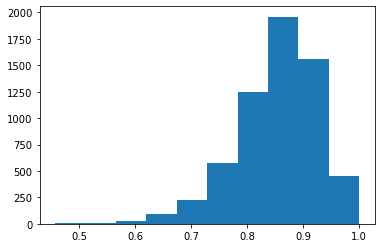

In [11]:
print(len(pos_test_similarities))
plt.hist(pos_test_similarities)
plt.show()

In [14]:
neg_test_similarities = []
temp_test_authors = deepcopy(test_authors)
random.seed(0)
random.shuffle(temp_test_authors)
for idx, aid in enumerate(tqdm(temp_test_authors[:1000])):
    known_pubs = [pid for pid in magfid2pids[aid] if pid in known_pids and pid2infos[pid]['abstract'] is not None]
    unknown_pubs = [pid for pid in magfid2pids[temp_test_authors[idx+1]] if pid in unknown_pids and pid2infos[pid]['abstract'] is not None]
    if (not known_pubs) or (not unknown_pubs):
        continue
    known_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in known_pubs], convert_to_tensor=True)
    unknown_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in unknown_pubs], convert_to_tensor=True)
    search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
    neg_test_similarities.extend([hit[0]['score'] for hit in search_hits])

100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]


3115


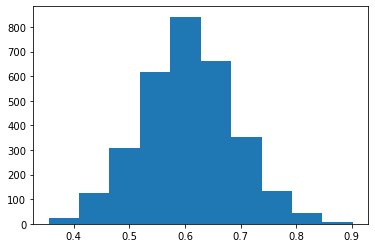

In [15]:
print(len(neg_test_similarities))
plt.hist(neg_test_similarities)
plt.show()

In [16]:
# Recall
len([1 for score in pos_test_similarities if score > 0.73]) / len(pos_test_similarities)

0.9420172161767094

In [17]:
# Precision
len([1 for score in pos_test_similarities if score > 0.73]) / (len([1 for score in pos_test_similarities if score > 0.7]) + len([1 for score in neg_test_similarities if score > 0.7]))

0.9139615505830444

In [18]:
# Accuracy
(len([1 for score in pos_test_similarities if score > 0.73]) + len([1 for score in neg_test_similarities if score <= 0.7])) / (len(pos_test_similarities) + len(neg_test_similarities))

0.9187877480586712

## Demo

In [25]:
# Load resources
with open('awfid2pids.pickle', 'rb') as f_in:
    awfid2pids = pickle.load(f_in)
with open('pid2awfids.pickle', 'rb') as f_in:
    pid2awfids = pickle.load(f_in)
with open('fname2awfids.pickle', 'rb') as f_in:
    fname2awfids = pickle.load(f_in)
with open('magfid2pids.pickle', 'rb') as f_in:
    magfid2pids = pickle.load(f_in)
with open('pid2magfids.pickle', 'rb') as f_in:
    pid2magfids = pickle.load(f_in)
with open('fname2magfids.pickle', 'rb') as f_in:
    fname2magfids = pickle.load(f_in)
with open('awfid2fname.pickle', 'rb') as f_in:
    awfid2fname = pickle.load(f_in)
with open('pid2infos.pickle', 'rb') as f_in:
    pid2infos = pickle.load(f_in)
with open('magfid2fname.pickle', 'rb') as f_in:
    magfid2fname = pickle.load(f_in)

print('1')
db = mysql.connector.connect(user='mag_readonly', password='j6gi48ch82nd9pff', host="mag-2020-09-14.mysql.database.azure.com",
   port=3306,
   database='mag_2020_09_14',
   ssl_ca="DigiCertGlobalRootCA.crt.pem",
   ssl_disabled=False)
cursor = db.cursor()

sentence_transformer = SentenceTransformer('allenai-specter').eval().cuda()

with open('co_author_train.pickle', 'rb') as f_in:
    sub_co_author_graph:nx.Graph = pickle.load(f_in)
id2idx = {id : idx for idx, id in enumerate(sub_co_author_graph.nodes)}

print('2')

nx_model = Net()
nx_model.load_state_dict(torch.load("save_model/checkpoints.gcn"))
nx_model.eval()
# embedding all nodes on the graph
graph = from_networkx(sub_co_author_graph, group_node_attrs=['emb'])

print('3')
embeddings = nx_model.encode(graph.x.float(), graph.edge_index)

In [76]:
target_author_name = list(set(fname2awfids.keys()) & set(fname2magfids.keys()))[18]
target_author_id = fname2awfids[target_author_name][0]

test_pid = -1
for fid in fname2magfids[target_author_name]:
    try:
        for pid in magfid2pids[fid]:
            if pid2infos[pid]['abstract'] is not None and len(pid2infos[pid]['authors']) >= 2:
                test_pid = pid
                break
        if test_pid >= 0:
            break
    except:
        pass
if test_pid >= 0:
    test_pub = {'title': pid2infos[test_pid]['title'],
                'abstract' : pid2infos[test_pid]['abstract'],
                'co_author' : [magfid2fname[fid] for fid in pid2infos[test_pid]['authors']]}
    print(target_author_id)
    print(test_pub)
    r = requests.get(url='http://128.174.136.27:5000', params={'target' : target_author_id, 
                                                           'title' : test_pub['title'], 
                                                           'abstract' : test_pub['abstract'],
                                                           'coauthor' : str(test_pub['co_author'])})
    print(r.content)

3083
{'title': 'joint data purchasing and data placement in a geo distributed data market', 'abstract': 'This paper studies design challenges faced by a geo-distributed cloud data market: which data to purchase (data purchasing) and where to place/replicate the data (data placement). We show that the joint problem of data purchasing and data placement within a cloud data market is NP-hard in general. However, we give a provably optimal algorithm for the case of a data market made up of a single data center, and then generalize the structure from the single data center setting and propose Datum, a near-optimal, polynomial-time algorithm for a geo-distributed data market.', 'co_author': ['xiaoqi ren', 'juba ziani', 'adam wierman', 'palma london']}
b'{"co_author_conclusion":true,"co_author_score":0.9317653973897299,"semantic_conclusion":true,"semantic_score":0.9998914003372192}\n'


In [43]:
with open('pid2magfids.pickle', 'rb') as f_in:
    pid2magfids = pickle.load(f_in)

In [70]:
co_author_score = None
coauthors = test_pub['co_author']
if coauthors is not None:
    print(1)
    # coauthors = eval(coauthors)
    target_author_name = awfid2fname[target_author_id]
    if target_author_name in fname2magfids:
        print(2)
        # Locate target author in MAG
        target_author_pids = awfid2pids[target_author_id]
        temp_coauthor_for_target_author = [set(pid2magfids[pid]) for pid in target_author_pids if pid in pid2magfids]
        if temp_coauthor_for_target_author:
            print(8)
            target_author_magfid = None
            for fids in temp_coauthor_for_target_author:
                if not fids:
                    continue
                for fid in fids:
                    if magfid2fname[fid] == target_author_name:
                        target_author_magfid = fid
                        break
                if target_author_magfid:
                    break
            if target_author_magfid in id2idx:
                print(5)
                target_author_emb = embeddings[id2idx[target_author_magfid]]
                if sub_co_author_graph.has_node(target_author_magfid):
                    print(6)
                    # Filter out coauthors not in the graph
                    recognized_coauthors = [fname2magfids[a] for a in coauthors if a in fname2magfids]
                    trained_coauthors = [[id for id in coauthor_ids if sub_co_author_graph.has_node(id)] for coauthor_ids in recognized_coauthors]
                    trained_coauthors = [coauthor_ids for coauthor_ids in trained_coauthors if coauthor_ids]
                    if trained_coauthors:
                        print(7)
                        scores = []
                        for trained_coauthor in trained_coauthors:
                            coauthor_emb = torch.index_select(embeddings, 0, torch.tensor([id2idx[id] for id in trained_coauthor]))
                            temp_score = torch.max(target_author_emb @ coauthor_emb.T).sigmoid().cpu().item()
                            scores.append(temp_score)
                        co_author_score = mean(scores)

1
2
8
5
6
7


In [71]:
co_author_score

0.9317653973897299

In [46]:
103340358 in pid2magfids

True

In [22]:
pid2infos[7971409]

KeyError: 7971409

In [45]:
[pid for pid in target_author_pids if pid in pid2magfids][18]

103340358

In [47]:
pid2magfids[103340358]

[2116657824, 2125104194, 2131539564, 2953597871, 2164603845]

In [33]:
temp_coauthor_for_target_author

[{2096731881, 2121939561, 2224413342, 2303897886, 2491264568, 2694791869},
 {2121939561},
 {2100860776, 2121939561, 2152766206},
 {2098136913, 2121939561, 2130957644, 2642048689},
 {149210974, 2121939561, 2722353157},
 {2121939561, 2304105079, 2777069086},
 {2110558983,
  2111579034,
  2121939561,
  2156633756,
  2171991132,
  2279782171,
  2288375955,
  2308328903,
  2315689540,
  2421938890,
  2639876267,
  2644058196},
 {2096731881, 2121939561, 2125104194, 2491264568},
 {76047928, 2121939561, 2207916209},
 {2121939561, 2163471192, 2164604393, 2165330392, 2682329375},
 {2121939561},
 {2096731881, 2121939561, 2664163432},
 {2121939561, 2156633756, 2461916229},
 {1991372327, 2121939561, 2618347989, 2632509234},
 {2121939561},
 {2121939561, 2164604393, 2682329375},
 {121171588, 2109621001, 2121939561, 2289816208},
 {2109031554, 2121939561, 2665773577},
 {2116657824, 2125104194, 2131539564, 2164603845, 2953597871},
 {2121939561, 2167963239, 2169716560, 2584136427},
 {2121939561, 24640785

In [53]:
target_author_magfid in id2idx

True

In [12]:
target_author_name

'jiawei han'

In [15]:
i = 1
print([magfid2fname[fid] for fid in pid2magfids[target_author_pids[i]]])
print(pid2magfids[target_author_pids[i]])

[]
[]


In [41]:
pid2magfids[awfid2pids[target_author_id][18]]

[]

In [42]:
awfid2pids[target_author_id][18]

66443818

In [40]:
for id in  {2116657824, 2125104194, 2131539564, 2164603845, 2953597871}:
    print(magfid2fname[id])

xifeng yan
philip s yu
tianyi wu
yizhou sun
ji hyea han


In [9]:
# sentence transformer score
known_pids = awfid2pids[target_author_id]
known_pubs = get_pub_info_from_mysql(known_pids, cursor)
known_emb = sentence_transformer.encode(['%s[SEP]%s' % (str(info.get('title')), str(info.get('abstract'))) for pid, info in known_pubs.items()], convert_to_tensor=True).cuda()
unknown_emb = sentence_transformer.encode(['%s[SEP]%s' % (test_pub['title'], test_pub['abstract'])], convert_to_tensor=True).cuda()
search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
semantic_score = search_hits[0][0]['score']
semantic_score

0.9999624490737915

In [33]:
# co author score
from statistics import mean
co_author_score = None
coauthors = test_pub['co_author']
if coauthors is not None:
    target_author_name = awfid2fname[target_author_id]
    if target_author_name in fname2magfids:
        # Locate target author in MAG
        target_author_pids = awfid2pids[target_author_id]
        temp_coauthor_for_target_author = [set(pid2magfids[pid]) for pid in target_author_pids if pid in pid2magfids]
        if temp_coauthor_for_target_author:
            possible_ids = temp_coauthor_for_target_author[0]
            for co in temp_coauthor_for_target_author:
                possible_ids = possible_ids & co
            if possible_ids:
                possible_ids = [id for id in possible_ids if magfid2fname[id] == target_author_name]
                if len(possible_ids) == 1:
                    target_author_magfid = possible_ids[0]
                    target_author_emb = embeddings[id2idx[target_author_magfid]]
                    if sub_co_author_graph.has_node(target_author_magfid):
                        # Filter out coauthors not in the graph
                        recognized_coauthors = [fname2magfids[a] for a in coauthors if a in fname2magfids]
                        trained_coauthors = [[id for id in coauthor_ids if sub_co_author_graph.has_node(id)] for coauthor_ids in recognized_coauthors]
                        trained_coauthors = [coauthor_ids for coauthor_ids in trained_coauthors if coauthor_ids]
                        if trained_coauthors:
                            scores = []
                            for trained_coauthor in trained_coauthors:
                                coauthor_emb = torch.index_select(embeddings, 0, torch.tensor([id2idx[id] for id in trained_coauthor]))
                                temp_score = torch.max(target_author_emb @ coauthor_emb.T).sigmoid().cpu().item()
                                scores.append(temp_score)
                            co_author_score = mean(scores)
co_author_score

0.7369004090627035

In [14]:
from torch_geometric.utils import negative_sampling
train_loader = NeighborLoader(data=graph, num_neighbors=[5, 7, 10], batch_size=128, 
                            shuffle=True, num_workers=12, directed = False)

it = iter(train_loader)
sampled_data = next(it)
pos_edge_index = sampled_data.edge_index
neg_edge_index = negative_sampling(edge_index=pos_edge_index,
    num_nodes=sampled_data.num_nodes, num_neg_samples=pos_edge_index.size(1))

z = nx_model.encode(sampled_data.x.float(), pos_edge_index)
edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
link_logits = nx_model.decode(z, edge_index)

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float).cuda()
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

labels = get_link_labels(pos_edge_index, neg_edge_index)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

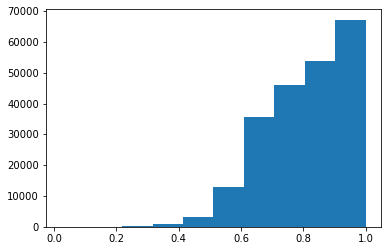

In [18]:
plt.hist(link_logits[labels.bool()].detach().sigmoid().cpu().numpy())
plt.show()

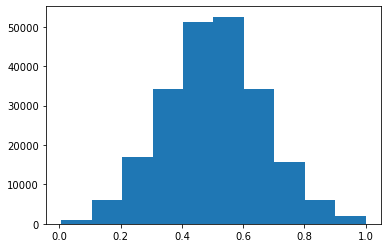

In [19]:
plt.hist(link_logits[~labels.bool()].detach().sigmoid().cpu().numpy())
plt.show()

In [31]:
torch.eq(link_logits.sigmoid().detach().cpu() > 0.65, labels.bool().cpu()).float().mean()

tensor(0.8451)

In [18]:
def generate_graphs_fast(core_author:str, candidate_ids:List[int], fid2pids:Dict[int, list], cursor:mysql.connector.cursor_cext.CMySQLCursor) -> List[nx.Graph]:
    temp_candidate_pids = []
    temp_candidate_split = []
    for candidate_id in candidate_ids:
        temp_pids = fid2pids[candidate_id]
        temp_candidate_pids.extend(temp_pids)
        temp_candidate_split.append(len(temp_pids))
        
    # Collect co_authors for this author
    pid2coauthor = {pid : pid2magfids[pid] for pid in temp_candidate_pids}
    authors = set()
    for _, co_authors in pid2coauthor.items():
        authors.update(co_authors)
    
    temp_magfid2pids = {fid : magfid2pids[fid] for fid in authors}
    pids = set()
    for _, pid in temp_magfid2pids.items():
        pids.update(pid)
    temp_pid2infos = {pid : pid2infos[pid] for pid in pids}
    start_idx = 0
    graphs = []
    core_author_ids = []
    for split in temp_candidate_split:
        graph = nx.Graph()
        core_author_id = None
        node_attributes = defaultdict(dict)
        for offset in range(split):
            temp_pid = temp_candidate_pids[start_idx + offset]
            co_authors = pid2coauthor[temp_pid]
            for co_author in co_authors:
                if co_author in node_attributes:
                    continue
                node_attributes[co_author]['pubs'] = [temp_pid2infos[pid] for pid in temp_magfid2pids[co_author]]
                node_attributes[co_author]['id'] = co_author
                if temp_magfid2pids[co_author] == core_author:
                    core_author_id = co_author
            graph.add_edges_from(combinations(co_authors, 2))
        nx.set_node_attributes(graph, node_attributes)
        graphs.append(graph)
        core_author_ids.append(core_author_id)
        start_idx += split
    return graphs, core_author_ids

In [27]:
with open('co_author_train.pickle', 'rb') as f_in:
    sub_co_author_graph:nx.Graph = pickle.load(f_in)

In [42]:
list(sub_co_author_graph.nodes)[114]

1973420239

In [28]:
for node in sub_co_author_graph.nodes:
    sub_co_author_graph.nodes[node]['id'] = node

In [30]:
g = from_networkx(sub_co_author_graph, group_node_attrs=['emb'])

In [38]:
id2idx = {int(id) : idx for idx, id in enumerate(g.id)}

In [37]:
list(id2idx.keys())[0]

tensor(2811232256)

In [43]:
id2idx[1973420239]

114

In [23]:
# co-author score
co_author_score = 0
fname = awfid2fname[target_author_id]
co_authors = list(set(test_pub['co_author']) - set([fname]))

mag_co_authors = {a : fname2magfids.get(a) for a in co_authors if a in fname2magfids}
aw_co_authors = {a : fname2awfids.get(a) for a in co_authors if a in fname2awfids}

if not mag_co_authors and not aw_co_authors:
    co_author_score = None
else:
    for fname, co_author_ids in mag_co_authors.items():
        graphs, core_author_ids = generate_graphs(fname, co_author_ids, magfid2pids, cursor)
        for i, graph in enumerate(graphs):
            nx.set_node_attributes(graph, {node : {'emb' : sentence_transformer.encode(['%s[SEP]%s' % (str(info.get('title')), str(info.get('abstract'))) for info in graph.nodes[node]['pubs'][:10]], convert_to_tensor=True).mean(axis=0).cpu().numpy()} for node in graph.nodes})
            for node in graph.nodes:
                del graph.nodes[node]['pubs']
            graphs[i] = from_networkx(graph, group_node_attrs=['emb'])

In [26]:
graphs[0]

Data(edge_index=[2, 50], id=[11], x=[11, 768])

In [15]:
list(graphs[0].nodes)[0]

2641761469

In [16]:
graphs[0].nodes[2641761469]

{'pubs': [{'title': 'qoe prediction model for mobile video telephony',
   'year': 2016,
   'abstract': 'Interactive online video applications, such as video telephony, are known for their vulnerability to network condition. With the increasing usage of hand-held wireless mobile devices, which are capable of capturing and processing good quality videos, combined with the flexibility in an end-user movements have added new challenging factors for application providers and network operators. These factors affect the perceived video quality of mobile video telephony applications, unlike conventional video telephony over desktop computers. We investigate this impact on video quality of mobile video telephony in varying network conditions and end-users movement scenarios. Based on 312 live traces, we quantitatively derive the correlation between the perceived video quality and the network Quality of Service (QoS) and user mobility. With the results, we develop a Quality of Experience (QoE) p

In [11]:
graphs[0].nodes[2505799736]

{'pubs': [{'title': 'comparison and analysis of outage probability signal power with interferences at differentfadding environment',
   'abstract': 'In this paper a mathematical method is presented to express the outage probability for a desired radio signal received from a mobile transmitter in the presence of single or multiple interfering signals with rician and Rayleigh fading. In contrast to previously reported analysis, this paper compares the outage probability & signal power at different fading environment. This is useful in determining the spectrum efficiency and performance of (interferencelimited) radio networks for cellular telephony, two-way paging, and another mobile data networks. For this analysis the interference may be single or multiple. In this paper we focus on the different parameters for output value of the different signals.'},
  {'title': 'modified power saving dsrprotocol for manet',
   'abstract': 'Mobile ad hoc network (MANET) is one of the important require

In [12]:
g = from_networkx(graphs[0], group_node_attrs=['emb'])

RuntimeError: Could not infer dtype of dict

In [12]:
a = deepcopy(graphs[0])

In [13]:
for node in a.nodes:
    del a.nodes[node]['pubs']

In [14]:
g = from_networkx(a, group_node_attrs=['emb'])

/home/keruiz2/miniconda3/envs/test2/lib/python3.9/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


In [18]:
net_model = Net()
net_model.load_state_dict(torch.load("save_model/checkpoints.gcn"))
net_model.eval()
temp = net_model.encode(g.x.float(), g.edge_index)

In [21]:
g.node_stores

[{'edge_index': tensor([[0, 0, 1, 1, 2, 2],
         [1, 2, 0, 2, 0, 1]]), 'x': tensor([[-1.0602, -0.1022, -0.1451,  ..., -0.0235, -0.3256,  0.5582],
         [-0.8126, -0.1739,  0.2327,  ...,  0.1626, -0.0941,  0.3809],
         [-0.8126, -0.1739,  0.2327,  ...,  0.1626, -0.0941,  0.3809]])}]

In [20]:
temp.shape

torch.Size([3, 64])

## REST API

In [4]:
r = requests.get(url='http://128.174.136.27:5000', params={'target' : target_author_id, 'title' : test_pub['title'], 'abstract' : test_pub['abstract']})

In [5]:
r.content

b'{"belongs":true,"score":0.9999966621398926,"semantic_score":0.9999966621398926}\n'

## Co-author model

In [3]:
co_author_graph = nx.read_gpickle('co_author.gpickle')

In [6]:
for fid in fname2magfids['jiawei han']:
    if len(magfid2pids[fid]) > 2:
        print(fid)
        break

2481136225


In [7]:
magfid2pids[2481136225]

[2588653406, 2588130785, 2606596562, 2594747861]

In [12]:
list(co_author_graph.neighbors(fid))

[2421381473, 2596073846, 2634032582, 2682291320]

In [3]:
with open("data/co_author_graph.pickle", "rb") as f:
    G = pickle.load(f)

In [2]:
with open("co_author_train.pickle", "rb") as f:
    G_ = pickle.load(f)

In [4]:
G.number_of_nodes()

511122

In [12]:
a = [type(G_.nodes[node]['emb']) == torch.Tensor for node in G_.nodes]

In [14]:
temp_g = deepcopy(G_)

In [15]:
for node in temp_g.nodes:
    temp_g.nodes[node]['emb'] = temp_g.nodes[node]['emb'].numpy()

In [18]:
with open('co_author_train.pickle', 'wb') as f_out:
    pickle.dump(temp_g, f_out)

In [17]:
g = from_networkx(G_, group_node_attrs=['emb'])

AttributeError: 'list' object has no attribute 'dim'

In [8]:
G.nodes[list(G.nodes)[0]]['embedding']

array([-3.83406907e-01, -2.29716578e-02,  1.32044069e-01, -4.23265263e-01,
        3.60059410e-01,  2.48803705e-01,  1.57187540e-01, -1.50067512e-01,
        2.00297039e-01,  4.60864693e-01,  1.43152304e-01,  9.72815268e-02,
        1.59987584e-01,  1.26034940e-01, -3.75966802e-02,  3.24566543e-01,
       -6.42810403e-02,  4.95905057e-02, -1.34060048e-01,  1.98774252e-01,
        4.40339126e-01,  3.51164028e-01,  1.19269423e-01, -1.76217936e-01,
        7.02541173e-02, -1.59523960e-01,  2.75054470e-01,  6.00995012e-02,
       -1.94816194e-01,  5.12140438e-01, -3.04766186e-02, -3.38034771e-01,
       -9.19010583e-03,  2.59515187e-01, -4.85355556e-02, -3.79484594e-02,
        5.36845908e-01, -2.29275670e-01, -1.73151212e-01, -2.68819928e-03,
        1.08135362e-01, -2.73428857e-03,  1.03329023e-01,  8.09529163e-02,
       -2.60711253e-01,  3.27954397e-01,  1.54172681e-01, -3.49188834e-01,
       -8.37259516e-02,  2.42574299e-01, -2.60069199e-01,  4.16072726e-01,
       -1.48320301e-01,  

In [41]:
G.number_of_edges()

602770

In [19]:
g = from_networkx(G, group_node_attrs=['embedding'])

In [20]:
train_loader = NeighborLoader(data=g, num_neighbors=[5, 5, 5], batch_size=128, 
                               shuffle=True, num_workers=12, directed = False)

In [21]:
len(train_loader)

3994

In [59]:
for sample in train_loader:
    break

In [60]:
sample.size

<bound method BaseData.size of Data(edge_index=[2, 50150], c=[14510261], num_nodes=7933, batch_size=128)>

In [ ]:
co_author = 'Jiawei Han'
aw_candidate_ids = fname2awfids.get(co_author.lower())
if aw_candidate_ids is not None:
    aw_graphs = generate_graphs(aw_candidate_ids, awfid2pids, pid2awfids)

mag_candidate_ids = fname2magfids.get(co_author.lower())
if mag_candidate_ids is not None:
    mag_graphs = generate_graphs(mag_candidate_ids, magfid2pids, pid2magfids)

In [ ]:
max([len(list(mag_graphs[i].nodes)) for i in range(len(mag_graphs))])

In [ ]:
mag_graphs[0].nodes[2721444824]['pids']

In [ ]:
cursor.execute('show databases;')

In [ ]:
cursor.execute('use mag_2020_09_14;')

In [24]:
cursor.execute('show tables;')

In [10]:
cursor.execute('describe authors;')

In [26]:
cursor.execute('describe paperauthoraffiliations;')

In [27]:
myresult = cursor.fetchall()
for x in myresult:
    print(x)

('PaperId', b'bigint', 'NO', 'MUL', None, '')
('AuthorId', b'bigint', 'NO', 'MUL', None, '')
('AffiliationId', b'bigint', 'YES', 'MUL', None, '')
('AuthorSequenceNumber', b'int', 'YES', '', None, '')


In [ ]:
cursor.execute('select Abstract from paperabstracts where PaperId in (%s)' % ','.join([str(pid) for pid in mag_graphs[0].nodes[2721444824]['pids']]))

In [13]:
cursor.execute('select PaperId, PaperTitle from papers where PaperId in (%s)' % ','.join([str(pid) for pid in known_pubs]))

In [ ]:
cursor.execute('select * from authors where DisplayName="Jiawei Han" limit 5')

In [ ]:
cursor.execute('select * from paperauthoraffiliations where PaperId=21366')